_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [6]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [7]:
import pandas as pd
from pdpbox.pdp import pdp_interact_plot, pdp_interact
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import make_pipeline
# from pandas_profiling import ProfileReport # commenting as codegrade is throwing an error on pandas_profiling
import numpy as np
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
# raise NotImplementedError()

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [8]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url)
# Setting 'Inspection ID' as the index
df ['Inspection Date'] = pd.to_datetime(df ['Inspection Date'], infer_datetime_format=True)
df = df.set_index('Inspection Date')
df.head()

# raise NotImplementedError()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2017-09-15,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,2.0
2011-10-20,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,0.0
2016-04-05,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,0.0
2016-04-29,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,0.0
2011-01-10,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,0.0


**Task 1 Test**

In [9]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [10]:
'''T2. Identify data leakage column.'''
leaky_col = 'Serious Violations Found'
# YOUR CODE HERE
# raise NotImplementedError()

**Task 2 Test**

In [11]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [12]:
# finding high cardinality columns first
# commenting as codegrade is throwing an error on pandas_profiling
# profile = ProfileReport(df, minimal=True).to_notebook_iframe()


In [13]:
# get the column names to easily copy paste
print(df.columns.to_list())

['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', 'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location', 'Fail', 'Serious Violations Found']


In [14]:
'''T3. Write wrangle function.'''
def wrangle(df):
    df.drop(columns=[leaky_col, 'DBA Name', 'AKA Name', 'License #', 'Address', 'State', 'Violations', 'Location', 'Inspection ID' ], inplace=True)

    return df
# YOUR CODE HERE
# raise NotImplementedError()
df = wrangle(df)

In [15]:
# see the new dataframe to check how it looks
df.head()

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2017-09-15,Restaurant,Risk 1 (High),CHICAGO,60657.0,Canvass,41.938007,-87.644755,1
2011-10-20,Grocery Store,Risk 3 (Low),CHICAGO,60636.0,Complaint Re-Inspection,41.772402,-87.683603,0
2016-04-05,Restaurant,Risk 1 (High),CHICAGO,60649.0,Canvass Re-Inspection,41.758779,-87.575054,0
2016-04-29,Restaurant,Risk 2 (Medium),CHICAGO,60632.0,Canvass,41.812181,-87.707125,0
2011-01-10,School,Risk 1 (High),CHICAGO,60629.0,Canvass,NaN,NaN,0


**Task 3 Test**

In [16]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [17]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
X = df.drop(columns=target)
y = df[target]
# raise NotImplementedError()
X.shape, y.shape

((51916, 7), (51916,))

**Task 4 Test**

In [18]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [19]:
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE
# train subsetting
X_train = X[X.index.year < 2017]
y_train = y[y.index.year < 2017]

# test subsetting
X_val = X[X.index.year >= 2017]
y_val = y[y.index.year >= 2017]
X_train.shape, y_train.shape, X_val.shape, y_val.shape
# raise NotImplementedError()

((41827, 7), (41827,), (10089, 7), (10089,))

**Task 5 Testing**

In [20]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [21]:
'''T6. Establish baseline accuracy.'''
# the baseline of this problem is going to be the class that is in the majority
print(y_train.value_counts())
baseline_acc = 0
# raise NotImplementedError()
print('Baseline accuracy:', baseline_acc)

0    31398
1    10429
Name: Fail, dtype: int64
Baseline accuracy: 0


**Task 6 Testing**

In [22]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

AssertionError: `baseline_acc` should be type float. Have you defined the variable?

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [23]:
X_train.describe(include='all')

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude
count,41612,41815,41786,41801.000000,41826,41665.000000,41665.000000
unique,304,3,33,NaN,51,NaN,NaN
top,Restaurant,Risk 1 (High),CHICAGO,NaN,Canvass,NaN,NaN
freq,27436,29801,41626,NaN,19458,NaN,NaN
mean,NaN,NaN,NaN,60628.902849,NaN,41.878321,-87.676510
std,NaN,NaN,NaN,22.108896,NaN,0.081259,0.059333
min,NaN,NaN,NaN,60007.000000,NaN,41.644670,-87.914428
25%,NaN,NaN,NaN,60614.000000,NaN,41.823475,-87.708017
50%,NaN,NaN,NaN,60625.000000,NaN,41.889465,-87.666725
75%,NaN,NaN,NaN,60643.000000,NaN,41.938539,-87.634314


In [24]:
'''T7. Build model with bagging predictor.'''

# YOUR CODE HERE

model_bag = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, n_jobs=-1)
)
model_bag.fit(X_train, y_train);

**Tast 7 Testing**

In [25]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [26]:
'''T8. Build model with boosting predictor.'''
# importing again to correct codegrade error even though it is imported above too
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier

model_boost = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_estimators=100, verbosity=1, n_jobs=-1)
)
# raise NotImplementedError()
model_boost.fit(X_train, y_train);

[03:11:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


**Task 8 Testing**

In [27]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [28]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.907858560260119
Validation accuracy: 0.6816334621865398

Boosting Model
Training accuracy: 0.7880794701986755
Validation accuracy: 0.7023490930716622


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

In [29]:
'''T9. Plot ROC-curve.'''
# importing again to correct codegrade error even though it is imported above too
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier

y_pred_proba = model_bag.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# print the results
pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})
# raise NotImplementedError()

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.000000
1,0.000282,0.001001,1.000000
2,0.000282,0.001335,0.995455
3,0.000423,0.001335,0.991667
4,0.000705,0.002336,0.990000
...,...,...,...
3126,0.868866,0.940274,0.001600
3127,0.869007,0.940274,0.001579
3128,0.869289,0.940607,0.001429
3129,0.869571,0.940607,0.001071


Text(0, 0.5, 'True Positive Rate')

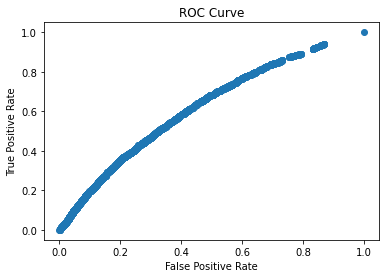

In [30]:
# importing again to correct codegrade error even though it is imported above too
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier

# See the results of the ROC curve on a plot
plt.scatter(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

##### PS: Due to the better score from the bagging model of RandomForest

In [31]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
model_cr = classification_report(y_val, model_bag.predict(X_val))
# raise NotImplementedError()
print(model_cr)

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7092
           1       0.44      0.26      0.33      2997

    accuracy                           0.68     10089
   macro avg       0.59      0.56      0.56     10089
weighted avg       0.65      0.68      0.65     10089



**Task 10 Testing**

In [32]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [33]:
'''T11. Create DataFrame of permutation importances.'''
import eli5
from eli5.sklearn import PermutationImportance

# transform X_val to X_val_transformed first

# make pipeline to transform
transformer = make_pipeline(
    ce.OrdinalEncoder()
)

#transform
X_val_transformed = transformer.fit_transform(X_val)

# get Permutation Importance now

permuter = PermutationImportance(
    model_bag,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

# get the index name
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names)
#make DataFrame
permutation_importances = pd.DataFrame({
    'importance_mean':np.std(permuter.feature_importances_),
    'importance_stdev':np.mean(permuter.feature_importances_)
}, index=feature_names)
# raise NotImplementedError()
permutation_importances

,importance_mean,importance_stdev
Facility Type,0.000986,-0.00085
Risk,0.000986,-0.00085
City,0.000986,-0.00085
Zip,0.000986,-0.00085
Inspection Type,0.000986,-0.00085
Latitude,0.000986,-0.00085
Longitude,0.000986,-0.00085


**Task 11 Testing**

In [34]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to use your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

(<Figure size 756x900 with 5 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': {'_pdp_x_ax': <AxesSubplot:xlabel='Longitude'>,
   '_pdp_y_ax': <AxesSubplot:ylabel='Latitude'>,
   '_pdp_inter_ax': <AxesSubplot:>}})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


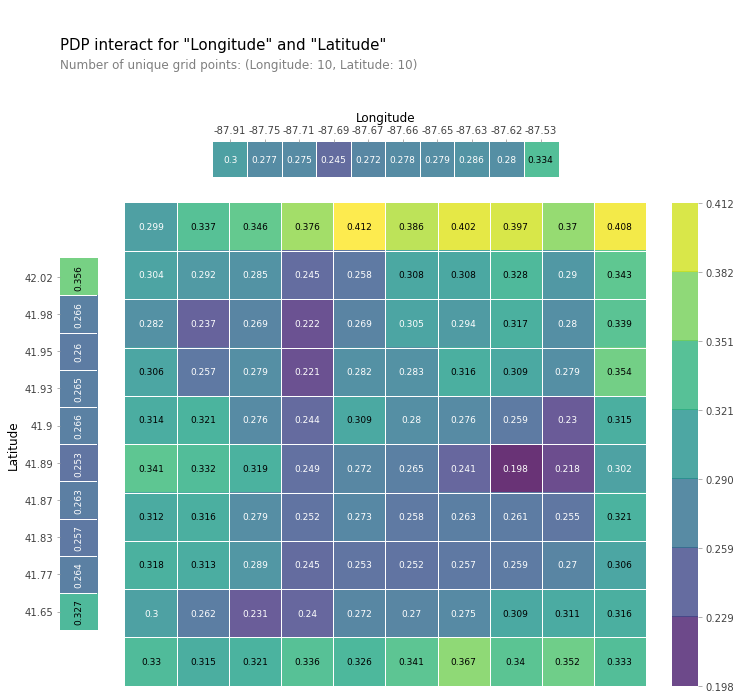

In [35]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
features = ['Longitude', 'Latitude']

# this is a multi feature problem so using pdp_interact_plot
# for partial dependence plot
#first make interaction object from pdp_interact that can be passed to pdp_interact_plot
interaction = pdp_interact(
    model=model_bag,
    dataset=X_val.dropna(),
    model_features=X_val.columns,
    features=features
)

#plot using pdp_interact_plot using the interaction object from pdp_interact
pdp_interact_plot(interaction,feature_names=features, plot_type='grid', plot_pdp=True)
# raise NotImplementedError()


What do you think? Is there a relationship between location and failing a food saftey inspection?